<a href="https://colab.research.google.com/github/mlelarge/dataflowr/blob/master/CEA_EDF_INRIA/VAE_filled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE for MNIST clustering and generation

The goal of this notebook is to explore some recent works dealing with variational auto-encoder (VAE).

We will use MNIST dataset and a basic VAE architecture. 

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics.cluster import normalized_mutual_info_score

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [3]:
batch_size = 128
data_dir = 'data'
# MNIST dataset
image_size = 784

dataset = torchvision.datasets.MNIST(root=data_dir,
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

# Variational Autoencoders

Consider a latent variable model with a data variable $x\in \mathcal{X}$ and a latent variable $z\in \mathcal{Z}$, $p(z,x) = p(z)p_\theta(x|z)$. Given the data $x_1,\dots, x_n$, we want to train the model by maximizing the marginal log-likelihood:
\begin{eqnarray*}
\mathcal{L} = \mathbf{E}_{p_d(x)}\left[\log p_\theta(x)\right]=\mathbf{E}_{p_d(x)}\left[\log \int_{\mathcal{Z}}p_{\theta}(x|z)p(z)dz\right],
  \end{eqnarray*}
  where $p_d$ denotes the empirical distribution of $X$: $p_d(x) =\frac{1}{n}\sum_{i=1}^n \delta_{x_i}(x)$.

 To avoid the (often) difficult computation of the integral above, the idea behind variational methods is to instea maximize a lower bound to the log-likelihood:
  \begin{eqnarray*}
\mathcal{L} \geq L(p_\theta(x|z),q(z|x)) =\mathbf{E}_{p_d(x)}\left[\mathbf{E}_{q(z|x)}\left[\log p_\theta(x|z)\right]-\mathrm{KL}\left( q(z|x)||p(z)\right)\right].
  \end{eqnarray*}
  Any choice of $q(z|x)$ gives a valid lower bound. Variational autoencoders replace the variational posterior $q(z|x)$ by an inference network $q_{\phi}(z|x)$ that is trained together with $p_{\theta}(x|z)$ to jointly maximize $L(p_\theta,q_\phi)$. The variational posterior $q_{\phi}(z|x)$ is also called the encoder and the generative model $p_{\theta}(x|z)$, the decoder or generator.

The first term $\mathbf{E}_{q(z|x)}\left[\log p_\theta(x|z)\right]$ is the negative reconstruction error. Indeed under a gaussian assumption i.e. $p_{\theta}(x|z) = \mathcal{N}(\mu_{\theta}(z), 1)$ the term $\log p_\theta(x|z)$ reduced to $\propto \|x-\mu_\theta(z)\|^2$, which is often used in practice. The term $\mathrm{KL}\left( q(z|x)||p(z)\right)$ can be seen as a regularization term, where the variational posterior $q_\phi(z|x)$ should be matched to the prior $p(z)= \mathcal{N}(0,1)$.

Variational Autoencoders were introduced by [Kingma and Welling](https://arxiv.org/abs/1312.6114), see also [Doersch](https://arxiv.org/abs/1606.05908) for a tutorial.

There are vairous examples of VAE in pytorch available [here](https://github.com/pytorch/examples/tree/master/vae) or [here](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/variational_autoencoder/main.py#L38-L65). The code below is taken from this last source.

In [4]:
# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

Here for the loss, instead of MSE for the reconstruction loss, we take BCE. The code below is still from the pytorch tutorial (with minor modifications to avoid warnings!).

In [9]:
# Start training
def train(model, data_loader, num_epochs):
    for epoch in range(num_epochs):
        for i, (x, _) in enumerate(data_loader):
            
            # Forward pass
            x = x.to(device).view(-1, image_size)
            x_reconst, mu, log_var = model(x)

            # Compute reconstruction loss and kl divergence
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

            # Backprop and optimize
            loss = reconst_loss + kl_div
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                       .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size, kl_div.item()/batch_size))

In [ ]:
# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 5
learning_rate = 1e-3

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train(model ,data_loader, num_epochs=3)

Let see how our network reconstructs our last batch. We display pairs of original digits and reconstructed version.

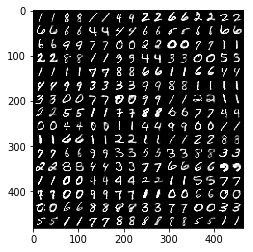

In [13]:
x,_ = next(iter(data_loader))
x = x.view(-1, image_size)

mu, _ = model.encode(x) 
out = model.decode(mu)
x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
out_grid = torchvision.utils.make_grid(x_concat).cpu().data
show(out_grid)

Let see now, how our network generates new samples.

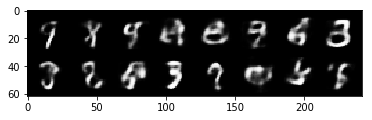

In [14]:
with torch.no_grad():
        z = torch.randn(16, z_dim).to(device)
#        z = -1*torch.ones(16, z_dim).to(device)
#        z[:,0] = torch.arange(-1,1,16)
        out = model.decode(z).view(-1, 1, 28, 28)

out_grid = torchvision.utils.make_grid(out).cpu()
show(out_grid)

Not great, but we did not train our network for long... That being said, we have no control of the generated digits. In the rest of this jupyter, we explore ways to generates zeros, ones, twos and so on. As a by product, we show how our VAE will allow us to do clustering.

The main idea is to build what we call a Gumbel VAE as described below.

# Gumbel VAE

Implement a VAE where you add a categorical variable $c\in \{0,\dots 9\}$ so that your latent variable model is $p(c,z,x) = p(c)p(z)p_{\theta}(x|,c,z)$ and your variational posterior is $q_{\phi}(c|x)q_{\phi}(z|x)$ as described in this NIPS [paper](https://arxiv.org/abs/1804.00104). Make minimal modifications to previous architecture...

The idea is that you incorporates a categorical variable in your latent space. You hope that this categorical variable will encode the class of the digit, so that your network can use it for a better reconstruction. Moreover, if things work as planed, you will then be able to generate digits conditionally to the class, i.e. you can choose the class thanks to the latent categorical variable $c$ and then generate digits from this class.

As noticed above, in order to sample random variables while still being able to use backpropagation required us to use the reparameterization trick which is easy for Gaussian random variables. For categorical random variables, the reparameterization trick is explained in this [paper](https://arxiv.org/abs/1611.01144). This is implemented in pytorch thanks to [F.gumbel_softmax](https://pytorch.org/docs/stable/nn.html?highlight=gumbel_softmax#torch.nn.functional.gumbel_softmax)

In [25]:
class VAE_Gumbel(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20, n_classes = 10):
        super(VAE_Gumbel, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(h_dim, n_classes)
        self.fc5 = nn.Linear(z_dim + n_classes, h_dim)
        self.fc6 = nn.Linear(h_dim, image_size)        
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        mu, log_var, log_p = self.fc2(h), self.fc3(h), F.log_softmax(self.fc4(h), dim=1)
        return mu, log_var, log_p
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y_onehot):
        latent = torch.cat((z, y_onehot),dim=1)
        h = F.relu(self.fc5(latent))
        x_reconst = torch.sigmoid(self.fc6(h))
        return x_reconst
    
    def forward(self, x):
        mu, log_var, log_p = self.encode(x)
        z = self.reparameterize(mu, log_var)
        y_onehot = F.gumbel_softmax(log_p)
        x_reconst = self.decode(z, y_onehot)
        #print(alpha)
        return x_reconst, mu, log_var, log_p

You need to modify the loss to take into account the categorical random variable with an uniform prior on $\{0,\dots 9\}$, see Appendix A.2 in the NIPS [paper](https://arxiv.org/abs/1804.00104)

In [26]:
def train_G(model, data_loader, num_epochs, beta = 1., verbose=True):
    nmi_scores = []
    model.train(True)
    for epoch in range(num_epochs):
        all_labels = []
        all_labels_est = []
        for i, (x, labels) in enumerate(data_loader):
            # Forward pass
            x = x.to(device).view(-1, image_size)
            x_reconst, mu, log_var, log_p = model(x)
            p = torch.exp(log_p)
            
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            p_uniform = 1/n_classes * torch.ones_like(p)
            entropy = torch.sum(p * torch.log(p / p_uniform))

            # Backprop and optimize
            loss = reconst_loss + kl_div + entropy
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if verbose:
                if (i+1) % 100 == 0:
                    print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}, Entropy: {:.4f}" 
                           .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size,
                                   kl_div.item()/batch_size, entropy.item()/batch_size))

In [31]:
n_classes = 10
z_dim = 16
model_G = VAE_Gumbel(z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

train_G(model_G, data_loader, num_epochs=3, verbose=True)

Epoch[1/3], Step [50/469], Reconst Loss: 207.3147, KL Div: 5.8186, Entropy: 0.0169
Epoch[1/3], Step [100/469], Reconst Loss: 166.2034, KL Div: 11.1000, Entropy: 0.0208
Epoch[1/3], Step [150/469], Reconst Loss: 152.1381, KL Div: 14.1306, Entropy: 0.0297
Epoch[1/3], Step [200/469], Reconst Loss: 135.3537, KL Div: 15.4264, Entropy: 0.0391
Epoch[1/3], Step [250/469], Reconst Loss: 134.1067, KL Div: 16.5843, Entropy: 0.0417
Epoch[1/3], Step [300/469], Reconst Loss: 121.6874, KL Div: 18.3681, Entropy: 0.0455
Epoch[1/3], Step [350/469], Reconst Loss: 116.0995, KL Div: 19.0247, Entropy: 0.0536
Epoch[1/3], Step [400/469], Reconst Loss: 116.6440, KL Div: 19.8938, Entropy: 0.0465
Epoch[1/3], Step [450/469], Reconst Loss: 106.6069, KL Div: 19.8138, Entropy: 0.0447
Epoch[2/3], Step [50/469], Reconst Loss: 105.5475, KL Div: 20.4304, Entropy: 0.0344
Epoch[2/3], Step [100/469], Reconst Loss: 107.9772, KL Div: 19.2137, Entropy: 0.0284
Epoch[2/3], Step [150/469], Reconst Loss: 103.5848, KL Div: 21.5795,

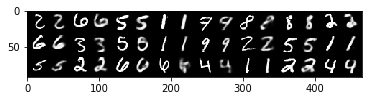

In [32]:
x,_ = next(iter(data_loader))
x = x[:24,:,:,:].to(device)
out, _, _, log_p = model_G(x.view(-1, image_size)) 
x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
out_grid = torchvision.utils.make_grid(x_concat).cpu().data
show(out_grid)

This was for reconstruction, but we care more about generation. For each category, we are generating 8 samples thanks to the following matrix, so that in the end, we should have on each line only one digit represented.

In [33]:
matrix = np.zeros((8,n_classes))
matrix[:,0] = 1
final = matrix[:]
for i in range(1,n_classes):
    final = np.vstack((final,np.roll(matrix,i)))

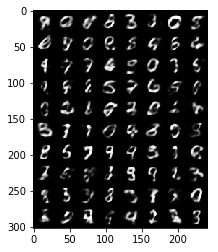

In [34]:
with torch.no_grad():
        z = torch.randn(8*n_classes, z_dim).to(device)
        y_onehot = torch.tensor(final).type(torch.FloatTensor).to(device)
        out = model_G.decode(z,y_onehot).view(-1, 1, 28, 28)

out_grid = torchvision.utils.make_grid(out).cpu()
show(out_grid)

It does not look like our original idea is working...

To check that our network is not using the categorical variable, we can track the [normalized mutual information](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html) between the true labels and the labels 'predicted' by our network (just by taking the category with maximal probability). Change your training loop to return the normalized mutual information (NMI) for each epoch. Plot the curve to check that the NMI is actually decreasing.

In order to force our network to use the categorical variable, we will change the loss following this ICLR [paper](https://openreview.net/forum?id=Sy2fzU9gl)

Implement this change in the training loop and plot the new NMI curve after 10 epochs. For $\beta = 20$, you should see that NMI increases. But reconstruction starts to be bad and generation is still poor.

This is explained in this [paper](https://arxiv.org/abs/1804.03599) and a solution is proposed see Section 5. Implement the solution described in Section 3 equation (7) if the NIPS [paper](https://arxiv.org/abs/1804.00104) 

In [50]:
from sklearn.metrics import normalized_mutual_info_score

def train_G_modified_loss(model, data_loader, num_epochs, beta=1 , C_z_fin=0, C_c_fin=0, verbose=True):
    nmi_scores = []
    model.train(True)
    NMI_history = []
    for epoch in range(num_epochs):
        
        C_z = C_z_fin * epoch/num_epochs
        C_c = C_c_fin * epoch/num_epochs
        
        for i, (x, labels) in enumerate(data_loader):
            # Forward pass
            x = x.to(device).view(-1, image_size)
            x_reconst, mu, log_var, log_p = model(x)
            p = torch.exp(log_p)
            
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            p_uniform = 1/n_classes * torch.ones_like(p)
            entropy = torch.sum(p * torch.log(p / p_uniform))
            #NMI = (p.max(1)[1]==labels).float().mean().item()
            NMI = normalized_mutual_info_score(labels.detach().numpy(), p.max(1)[1].numpy())
            NMI_history.append(NMI)
            
            # Backprop and optimize
            loss = reconst_loss + beta * ( abs(kl_div - C_z) + abs(entropy - C_c) )
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if verbose:
                if (i+1) % 100 == 0:
                    print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}, Entropy: {:.4f}" 
                           .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size,
                                   kl_div.item()/batch_size, entropy.item()/batch_size))
                    print('NMI : ',NMI)
            
    return NMI_history

Epoch[1/5], Step [50/469], Reconst Loss: 214.8887, KL Div: 0.0758, Entropy: 0.0006
NMI :  0.19043447854368428
Epoch[1/5], Step [100/469], Reconst Loss: 201.4421, KL Div: 0.0707, Entropy: 0.0011
NMI :  0.1762267631004331
Epoch[1/5], Step [150/469], Reconst Loss: 203.9348, KL Div: 0.0992, Entropy: 0.0025
NMI :  0.15875787219332593
Epoch[1/5], Step [200/469], Reconst Loss: 211.8976, KL Div: 0.0951, Entropy: 0.0067
NMI :  0.1590126249112451
Epoch[1/5], Step [250/469], Reconst Loss: 201.5923, KL Div: 0.1311, Entropy: 0.0402
NMI :  0.29487896726198143
Epoch[1/5], Step [300/469], Reconst Loss: 203.4517, KL Div: 0.0307, Entropy: 0.1514
NMI :  0.21373389741416993
Epoch[1/5], Step [350/469], Reconst Loss: 205.8802, KL Div: 0.0108, Entropy: 0.2261
NMI :  0.2752319679368709
Epoch[1/5], Step [400/469], Reconst Loss: 195.0943, KL Div: 0.0075, Entropy: 0.2570
NMI :  0.4177865623053056
Epoch[1/5], Step [450/469], Reconst Loss: 195.7413, KL Div: 0.0039, Entropy: 0.2410
NMI :  0.2874469458424057
Epoch[2

Text(0, 0.5, 'NMI')

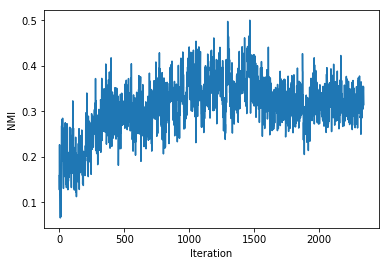

In [55]:
n_classes = 10
learning_rate = 0.005
model_G = VAE_Gumbel(z_dim = z_dim).to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

NMI = train_G_modified_loss(model_G, data_loader, num_epochs=5, beta=20, C_z_fin=100, C_c_fin=100, verbose=True)
plt.plot(NMI)
plt.xlabel('Iteration')
plt.ylabel('NMI')

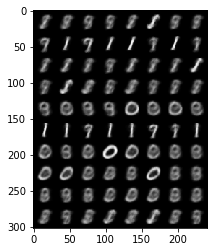

In [56]:
with torch.no_grad():
        z = torch.randn(8*n_classes, z_dim).to(device)
        y_onehot = torch.tensor(final).type(torch.FloatTensor).to(device)
        out = model_G.decode(z,y_onehot).view(-1, 1, 28, 28)
out_grid = torchvision.utils.make_grid(out).cpu()
show(out_grid)

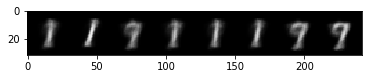

In [57]:
i = 1
with torch.no_grad():
    plt.plot()
    z = torch.randn(8, z_dim).to(device)
    y_onehot = torch.tensor(np.roll(matrix,i)).type(torch.FloatTensor).to(device)
    out = model_G.decode(z,y_onehot).view(-1, 1, 28, 28)
    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

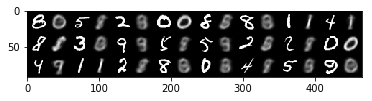

In [58]:
x,_ = next(iter(data_loader))
x = x[:24,:,:,:].to(device)
out, _, _, log_p = model_G(x.view(-1, image_size)) 
x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
out_grid = torchvision.utils.make_grid(x_concat).cpu().data
show(out_grid)

# Cheating by using labels

In [60]:
from sklearn.metrics import normalized_mutual_info_score

def train_G_labels(model, data_loader, num_epochs, beta=1, verbose=True):
    nmi_scores = []
    model.train(True)
    NMI_history = []
    for epoch in range(num_epochs):
        
        for i, (x, labels) in enumerate(data_loader):
            # Forward pass
            x = x.to(device).view(-1, image_size)
            x_reconst, mu, log_var, log_p = model(x)
            p = torch.exp(log_p)
            
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            NMI = normalized_mutual_info_score(labels.detach().numpy(), p.max(1)[1].numpy())
            NMI_history.append(NMI)
            
            label_loss = F.nll_loss(log_p, labels)
            
            # Backprop and optimize
            loss = reconst_loss + kl_div + beta * label_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if verbose:
                if (i+1) % 100 == 0:
                    print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}, Label Loss: {:.4f}" 
                           .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size,
                                   kl_div.item()/batch_size, label_loss/batch_size))
                    print('NMI : ',NMI)
            
    return NMI_history

Epoch[1/5], Step [50/469], Reconst Loss: 161.6988, KL Div: 9.7614, Label Loss: 0.0253
NMI :  0.2595154305764566
Epoch[1/5], Step [100/469], Reconst Loss: 135.7603, KL Div: 12.8553, Label Loss: 0.0224
NMI :  0.3978037111062232
Epoch[1/5], Step [150/469], Reconst Loss: 130.5132, KL Div: 13.5575, Label Loss: 0.0282
NMI :  0.4264007912643003
Epoch[1/5], Step [200/469], Reconst Loss: 111.2925, KL Div: 13.9432, Label Loss: 0.0195
NMI :  0.49198048143447815
Epoch[1/5], Step [250/469], Reconst Loss: 120.8844, KL Div: 15.5293, Label Loss: 0.0262
NMI :  0.3834905068216062
Epoch[1/5], Step [300/469], Reconst Loss: 110.3931, KL Div: 15.4016, Label Loss: 0.0274
NMI :  0.4657653606882572
Epoch[1/5], Step [350/469], Reconst Loss: 110.2928, KL Div: 16.7888, Label Loss: 0.0224
NMI :  0.5016829018023382
Epoch[1/5], Step [400/469], Reconst Loss: 108.9766, KL Div: 15.6556, Label Loss: 0.0226
NMI :  0.5496525223820641
Epoch[1/5], Step [450/469], Reconst Loss: 102.6861, KL Div: 15.9975, Label Loss: 0.0233
N

Text(0, 0.5, 'NMI')

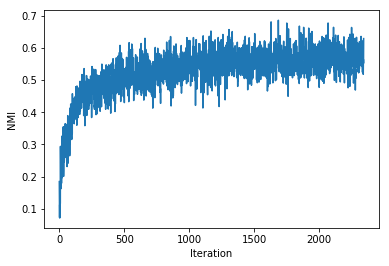

In [95]:
n_classes = 10
learning_rate = 0.01
model_G = VAE_Gumbel(z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

NMI = train_G_labels(model_G, data_loader, num_epochs=5, beta=10, verbose=True)
plt.plot(NMI)
plt.xlabel('Iteration')
plt.ylabel('NMI')

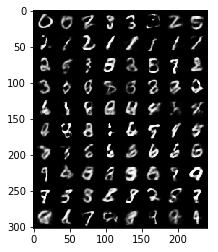

In [96]:
with torch.no_grad():
        z = torch.randn(8*n_classes, z_dim).to(device)
        y_onehot = torch.tensor(final).type(torch.FloatTensor).to(device)
        out = model_G.decode(z,y_onehot).view(-1, 1, 28, 28)
out_grid = torchvision.utils.make_grid(out).cpu()
show(out_grid)

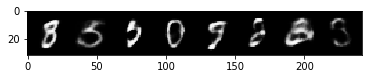

In [99]:
i = 3
with torch.no_grad():
    plt.plot()
    z = torch.randn(8, z_dim).to(device)
    y_onehot = torch.tensor(np.roll(matrix,i)).type(torch.FloatTensor).to(device)
    out = model_G.decode(z,y_onehot).view(-1, 1, 28, 28)
    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

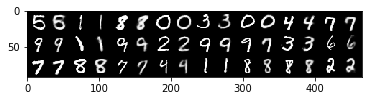

In [67]:
x,_ = next(iter(data_loader))
x = x[:24,:,:,:].to(device)
out, _, _, log_p = model_G(x.view(-1, image_size)) 
x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
out_grid = torchvision.utils.make_grid(x_concat).cpu().data
show(out_grid)